In [1]:
# SGD 구현
class SGD:
  def __init__(self, lr=0.1):
    self.lr = lr # learning rate 설정

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key] # lr와 기울기를 곱해서 가중치를 빼면서 업데이트

In [2]:
# Momentum 구현
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None # 물체의 속도를 의미하며 초기화때는 아무 값도 설정하지 않음

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] # 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 의미
      params[key] += self.v[key]

In [3]:
# AdaGrad 구현
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.keys():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key] # 기존 기울기 값을 제곱하여 계속 덧셈
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 학습률 감소가 매개 변수의 원소마다 다르게 적용된다는 의미

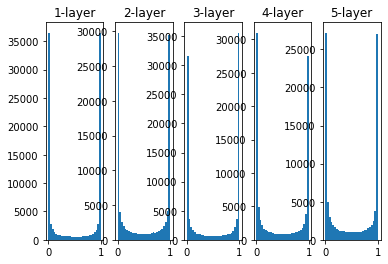

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100 # 은닉층 뉴런 수
hidden_layer_size = 5 # 은닉층 갯수
activations = {} # 활성화 결과 저장

for i in range(hidden_layer_size):
  if i != 0:
    x = activations[i-1]

  w = np.random.randn(node_num, node_num) * 1 # 0과 1에 분포 되어 있으며 기울기 값이 점점 작아지다가 사라지는 기울기 소실 문제 발생
  #w = np.random.randn(node_num, node_num) * 0.01 # 0.5 부근에 분포 되어 있기 때문에 기울기 소실 문제 발생하지 않음
  #w = np.random.randn(node_num, node_num) / np.sqrt(1.0/node_num) # Xavier 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼짐
  #w = np.random.randn(node_num, node_num) / np.sqrt(2.0/node_num) # ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요
  a = np.dot(x, w)
  z = sigmoid(a) # sigmoid, tanh함수는 좌우 대칭이라 중앙부근이 선형인 함수
  activations[i] = z


for i, a in activations.items():
  plt.subplot(1, len(activations), i+1)
  plt.title(str(i+1)+ "-layer")
  plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

In [5]:
# 곱셈계층 구현

class MulLayer:
  def __init__(self): # 인스턴스 변수 x,y 초기화
    self.x = None
    self.y = None

  def forward(self, x, y): # 순전파
    self.x = x # 입력한 x값으로 설정
    self.y = y # 입력한 y값으로 설정
    out = x * y # x와 y를 곱해서 출력
    return out

  def backward(self, dout): # 역전파
    dx = dout * self.y # 상류에서 미분한 값과 순전파 때 x였기 때문에 서로 바꿔서 y를 곱함
    dy = dout * self.x # 상류에서 미분한 값과 순전파 때 y였기 때문에 서로 바꿔서 x를 곱함
    return dx, dy

In [13]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300] # 오버피팅 재현
t_train = t_train[:300]

weight_decay_lambda = 0.1 # 가중치 감소 설정

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                        output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

In [14]:
# Dropout 구현
class Dropout:
  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, x, train_flg=True):
    if train_flg:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio # mask은 x와 형상이 같은 배열을 무작위로 생성하고 dropout_ratio보다 큰 원소만 True설정
      return x * self.mask
    
    else:
      return x * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask # 역전파는 ReLU처럼 동작

In [16]:
# Validation 분리 구현
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train) # 데이터 셔플

val_rate = 0.2 # validation 비율
val_num = int(x_train.shape[0]*val_rate)

x_val = x_train[:val_num]
t_val = t_train[:val_num]
x_train = x_train[val_num:]
t_train = t_train[val_num:]

print(x_val.shape)
print(t_val.shape)
print(x_train.shape)
print(t_train.shape)

(12000, 784)
(12000,)
(48000, 784)
(48000,)
